In [1]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from gensim import corpora
import pickle
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from gensim import models

from gensim.models import LsiModel, HdpModel


In [2]:
from contextualized_topic_models.models.ctm import CTM
#import os
#import pickle
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file
from contextualized_topic_models.evaluation.measures import CoherenceNPMI

## This is the full dataset 

In [3]:
dataset = pd.read_csv("/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/full_text_dataset.csv")

In [4]:
dataset.head()

,name,text
0,R12.pdf,DISCUSSION PAPER ON ARTIFICIAL INTELLIGENCE (A...
1,R13.pdf,DISCUSSION PAPER ON ARTIFICIAL INTELLIGENCE (A...
2,R39.pdf,Guidance\n\nCode of conduct for data-\ndriven ...
3,R11.pdf,...
4,R10.pdf,Privacy and Freedom of Expression in the Age ...


In [5]:
failed_pdf = dataset[dataset['text'].isnull()]

In [6]:
failed_pdf.head()

,name,text


In [7]:
dataset = dataset[~dataset['text'].isnull()]

## This is the lemmatized version of the data set

In [15]:
lemmatized_dataset = pd.read_csv("/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/lemmatized_dataset.csv")
del lemmatized_dataset['Unnamed: 0']

In [16]:
lemmatized_dataset.head()

,name,text
0,R12.pdf,ability ability able able able able acceptance...
1,R13.pdf,ability ability able able able able acceptance...
2,R39.pdf,abide ability able academia academic acceptabl...
3,R11.pdf,able able abuse abuse abuse abuse academic aca...
4,R10.pdf,ability ability ability ability ability abilit...


In [17]:
lemmatized_dataset = lemmatized_dataset[~lemmatized_dataset['text'].isnull()]

In [18]:
lemmatized_dataset.shape

(118, 2)

### Helper methods used in the contextualized topic model section

In [19]:
def read_dataset(dataset_path, lemm_dataset_path):
    # ## This is the full dataset
    dataset = pd.read_csv(dataset_path)
    dataset = dataset[~dataset['text'].isnull()]

    failed_pdf = dataset[dataset['text'].isnull()]
    print('failed documents : '+str(failed_pdf.shape))

    

    # ## This is the lemmatized version of the data set
    lemmatized_dataset = pd.read_csv(lemm_dataset_path)

    lemmatized_dataset = lemmatized_dataset[~lemmatized_dataset['text'].isnull()]

    return dataset, lemmatized_dataset

In [20]:
def convert_dataset(dataset):
    text_data = []
    for text in dataset['text']:
        tokens = text.split(" ")
        # print(len(tokens))
        new_tokens = []
        for token in tokens:
            if len(token) >= 3:  # and token not in ['technology', 'artificial', 'intelligence', 'datum']:
                new_tokens.append(token)
        text_data.append(new_tokens)
    """with open('dataset.csv') as f:
        for line in f:
            tokens = prepare_text_for_lda(line)
            if random.random() > .99:
                print(tokens)
                text_data.append(tokens)"""

    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    return dictionary, corpus, text_data


# LDA model using sklearn

In [21]:
count_vectorizer_lemm = CountVectorizer()
td_idf_vectorizer_lemm = TfidfVectorizer(min_df=1)
word_counts_lemm = count_vectorizer_lemm.fit_transform(lemmatized_dataset['text'].values)
td_idfs_lemm = td_idf_vectorizer_lemm.fit_transform(lemmatized_dataset['text'].values)

In [22]:
td_idfs_feature_names = td_idf_vectorizer_lemm.get_feature_names()
word_count_feature_names = count_vectorizer_lemm.get_feature_names()

#### here i was trying to delete the words that were appearing either in nearly all documents, either in none. So far, this gave really weird results when running the LDA but it might just be a simple coding mistake. 

In [260]:
#get tfidf vector for first document
#first_document_vector=tf_idf_vector[0]

#print the scores
#df = pd.DataFrame(td_idfs_lemm.T.todense(), index=td_idfs_feature_names)
#df.sort_values(by=["tfidf"],ascending=False)

In [264]:
#wc = pd.DataFrame(word_counts_lemm.T.todense(), index=word_count_feature_names)

In [286]:
#wc['sums'] = wc.sum(axis=1)
#wc["non-zero-sums"] = wc.astype(bool).sum(axis=1)
#print(wc.shape)

In [282]:
#wc = wc[wc['non-zero-sums']<=93]
#wc = wc[wc['non-zero-sums'] >2]

In [283]:
#word_count_feature_names = wc.index

### Start of the LDA

In [27]:

no_topics=10

#nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(td_idfs_lemm)

# Run LDA 
#using word counts
lda_wc = LatentDirichletAllocation(n_components=no_topics, doc_topic_prior=1, topic_word_prior=1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(word_counts_lemm)
#using td-idfs
lda_tdidfs = LatentDirichletAllocation(n_components=no_topics, doc_topic_prior=1, topic_word_prior=1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(td_idfs_lemm)

In [28]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("TOPICS WITH WORD COUNTS")
display_topics(lda_wc, word_count_feature_names, no_top_words)
print("TOPICS WITH TD-IDFS")
display_topics(lda_tdidfs, td_idfs_feature_names, no_top_words)
#display_topics(lda, td_idfs_feature_names, no_top_words)

TOPICS WITH WORD COUNTS
Topic 0:
ai system use datum machine human decision ethical make intelligence
Topic 1:
ai datum system use human intelligence technology artificial need work
Topic 2:
ai system datum use human intelligence technology development also data
Topic 3:
ai datum use system human make technology need may decision
Topic 4:
ai datum use system human intelligence technology research may need
Topic 5:
ai datum human machine intelligence system use technology artificial learning
Topic 6:
ai use datum system human technology intelligence artificial may make
Topic 7:
ai datum system use human technology decision right may artificial
Topic 8:
ai system use decision technology datum ethical data design work
Topic 9:
use ai human datum system technology may artificial intelligence work
TOPICS WITH TD-IDFS
Topic 0:
ai system important use decision machine vera palmanteer aspirin responsible
Topic 1:
ai datum bulb system tilde nao méditerranée list use lens
Topic 2:
ai datum syste

from reading the topics above, i observe a few things. 
1. using word-counts, the topics have words that are very generic to all documents (technology, ai, system, artificial, human ...) which makes the topics look very much alike
2. the td-idfs returns more unique words, but that don't necessarily have a meaning

In [20]:
print("SCORES WITH WORD COUNT")
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_wc.score(word_counts_lemm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_wc.perplexity(word_counts_lemm))

# See model parameters
print(lda_wc.get_params())

print("SCORES WITH TD-IDFS")
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_tdidfs.score(td_idfs_lemm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tdidfs.perplexity(td_idfs_lemm))

# See model parameters
print(lda_tdidfs.get_params())

SCORES WITH WORD COUNT
Log Likelihood:  -8105008.894530205
Perplexity:  2705.950110559823
{'batch_size': 128, 'doc_topic_prior': 1, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': 1, 'total_samples': 1000000.0, 'verbose': 0}
SCORES WITH TD-IDFS
Log Likelihood:  -21618.037818475197
Perplexity:  129161.02447428336
{'batch_size': 128, 'doc_topic_prior': 1, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': 1, 'total_samples': 1000000.0, 'verbose': 0}


## Try the Grid Search approach in order to find the best model

Loads of code taken from : https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/ 
MANY THANKSS!!

i saw above that the td-idfs was giving weird results in the sense that it was outputting words that didnt really have a meaning. For now, i am then basing the rest of the word on the word counts measures. 

In [69]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(word_counts_lemm)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [80]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(word_counts_lemm))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -1752723.216705932
Model Perplexity:  2249.1538001198483


In [82]:
display_topics(best_lda_model, word_count_feature_names, no_top_words)

Topic 0:
ai human right technology principle use system decision law see
Topic 1:
ai human use system robot technology ethical may datum intelligence
Topic 2:
ai datum use system machine decision data model may learning
Topic 3:
ai report intelligence system use artificial company new datum worker
Topic 4:
ai intelligence datum artificial research algorithm public use technology also


It seems like 5 topics is reaching the best result. However, it could also be that the best result would simply 1 single topic, under which all documents would be, and that could be a reason why the n of topics is low. 

In [71]:
model_results = pd.DataFrame(model.cv_results_)

In [72]:
model_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.141541,0.088025,0.059444,0.006649,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-1.183058e+06,-2.131234e+06,-1.698348e+06,-1.584012e+06,-2.192822e+06,-1.757895e+06,372226.579478,2
1,3.069212,0.111290,0.081563,0.005114,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-1.230263e+06,-2.183727e+06,-1.795134e+06,-1.634442e+06,-2.256258e+06,-1.819965e+06,375621.527994,6
2,4.191308,1.293679,0.107251,0.012536,0.5,15,"{'learning_decay': 0.5, 'n_components': 15}",-1.250447e+06,-2.234823e+06,-1.830595e+06,-1.681075e+06,-2.311937e+06,-1.861775e+06,387080.659247,8
3,5.901889,1.392367,0.140530,0.037935,0.5,20,"{'learning_decay': 0.5, 'n_components': 20}",-1.295447e+06,-2.268581e+06,-1.892911e+06,-1.688302e+06,-2.368648e+06,-1.902778e+06,391355.135305,12
4,5.437712,0.483994,0.166646,0.023713,0.5,25,"{'learning_decay': 0.5, 'n_components': 25}",-1.301386e+06,-2.318364e+06,-1.929168e+06,-1.743868e+06,-2.419663e+06,-1.942490e+06,404874.899174,15


## Plot the models comparison

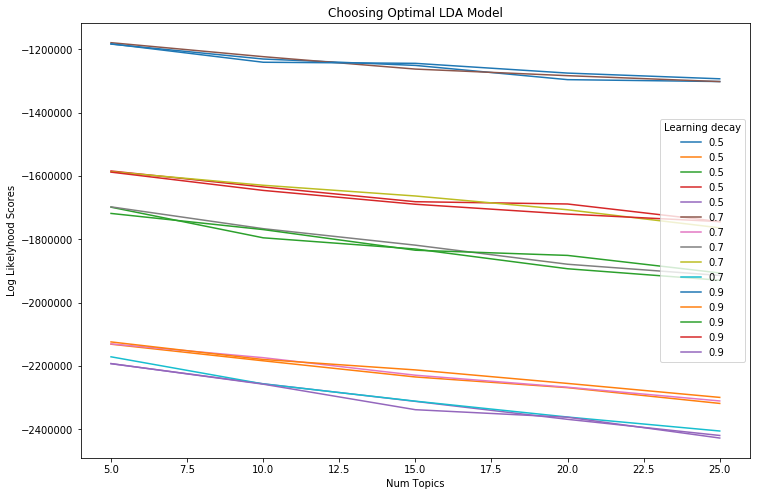

In [84]:
# Get Log Likelyhoods from Grid Search Output

n_topics = [5, 10, 15, 20, 25]

decay_5 =  model_results[model_results['param_learning_decay']==0.5]
decay_7 =  model_results[model_results['param_learning_decay']==0.7]
decay_9 =  model_results[model_results['param_learning_decay']==0.9]

log_likelyhoods_5 = decay_5[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]
log_likelyhoods_7 = decay_7[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]
log_likelyhoods_9 = decay_9[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']]




#log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.params['learning_decay']==0.5]
#log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.params['learning_decay']==0.7]
#log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.params['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## View dominant topics per document

In [85]:
lemmatized_dataset['name']

0     R12.pdf
1     R13.pdf
2     R39.pdf
3     R11.pdf
4     R10.pdf
       ...   
93    R34.pdf
94    R22.PDF
95    R36.pdf
96    R37.pdf
97    R23.pdf
Name: name, Length: 95, dtype: object

In [86]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(td_idfs_lemm)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = lemmatized_dataset["name"]
print(docnames)
#print(docnames)

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

0     R12.pdf
1     R13.pdf
2     R39.pdf
3     R11.pdf
4     R10.pdf
       ...   
93    R34.pdf
94    R22.PDF
95    R36.pdf
96    R37.pdf
97    R23.pdf
Name: name, Length: 95, dtype: object


,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
name,,,,,,
R12.pdf,0.010000,0.010000,0.950000,0.010000,0.010000,2
R13.pdf,0.010000,0.010000,0.950000,0.010000,0.010000,2
R39.pdf,0.010000,0.010000,0.950000,0.010000,0.010000,2
R11.pdf,0.940000,0.010000,0.010000,0.010000,0.010000,0
R10.pdf,0.550000,0.420000,0.010000,0.010000,0.010000,0
R38.pdf,0.020000,0.020000,0.930000,0.020000,0.020000,2
R14.pdf,0.010000,0.120000,0.760000,0.100000,0.010000,2
R28.pdf,0.580000,0.210000,0.190000,0.010000,0.010000,0
R29.pdf,0.800000,0.010000,0.010000,0.170000,0.010000,0


## Review topic distribution across documents

In [87]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,46
1,1,17
2,0,17
3,4,8
4,3,7


## Try with Gensim Library

In [29]:
lemmatized_dataset = lemmatized_dataset[~lemmatized_dataset['text'].isnull()]

In [30]:
text_data = []
for text in lemmatized_dataset['text']:
    tokens = text.split(" ")
    #print(len(tokens))
    new_tokens=[]
    for token in tokens:
        if len(token)>=4 :#and token not in ['technology', 'artificial', 'intelligence', 'datum']:
            new_tokens.append(token)
    text_data.append(new_tokens)
"""with open('dataset.csv') as f:
    for line in f:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            print(tokens)
            text_data.append(tokens)"""

"with open('dataset.csv') as f:\n    for line in f:\n        tokens = prepare_text_for_lda(line)\n        if random.random() > .99:\n            print(tokens)\n            text_data.append(tokens)"

In [31]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [48]:
#tfidf = models.TfidfModel(corpus, id2word=dictionary)

#low_value = 0.0005
#low_value_words = []
#all_words = 0
#for bow in corpus:
#    print(bow)
    #low_value_words += [id for id, value in tfidf[bow] if value < low_value]
#print(len(low_value_words))
#print(all_words)


In [240]:
#dictionary.filter_tokens(bad_ids=low_value_words)
#new_corpus = [dictionary.doc2bow(text) for text in text_data]

In [32]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')
#corpus=new_corpus

In [33]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS,id2word=dictionary, passes=15)
#ldamodel.save('model15.gensim')
topics = ldamodel.print_topics(num_words=10)

In [34]:
# Compute Perplexity
#print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.41809030223806465


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.006736  0.033073       1        1  26.330742
5      0.048383  0.042662       2        1  13.951610
9      0.080444 -0.015209       3        1  13.035629
0      0.067590  0.069652       4        1   9.903697
8      0.035429 -0.080737       5        1   8.991976
1      0.035153 -0.053570       6        1   8.891938
3      0.024917  0.053180       7        1   7.593390
6      0.030650 -0.102117       8        1   6.363604
7      0.017232  0.052688       9        1   4.936253
2     -0.346533  0.000378      10        1   0.001165, topic_info=            Term         Freq        Total Category  logprob  loglift
652        robot  2357.000000  2357.000000  Default  30.0000  30.0000
202        datum  9782.000000  9782.000000  Default  29.0000  29.0000
368        human  7954.000000  7954.000000  Default  28.0000  28.0000
1005  healthcare  1408.000000  1408.000000  Default  27.0000  27.0000
650        right  4119.000000  4119.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
632       report     0.001932  2693.055908  Topic10  -8.7192  -2.7878
650        right     0.002059  4119.801270  Topic10  -8.6554  -3.1492
200         data     0.002012  3667.171387  Topic10  -8.6784  -3.0558
811         well     0.001919  2747.400146  Topic10  -8.7256  -2.8143
342   government     0.001924  2815.161133  Topic10  -8.7231  -2.8360

[876 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10079      1  0.950927  aadhaar
19116      7  0.935023   aarons
1          1  0.158485     able
1          2  0.108343     able
1          3  0.368904     able
...      ...       ...      ...
19897      2  0.069651    zafar
19897      7  0.905460    zafar
6564       9  0.857996    čapek
11957      1  0.974690     ﬁeld
11974      1  0.941811     ﬁrst

[2988 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 10, 1, 9, 2, 4, 7, 8, 3])

### LDA MALLET - implementation

In [94]:
NUM_TOPICS = 20
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/users/marion1meyers/documents/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS,alpha=8, id2word=dictionary)

In [95]:


# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5647850897478291


In [96]:
# Show Topics
ldamallet.print_topics(num_words=10)

[(0,
  '0.022*"license" + 0.021*"ieee" + 0.019*"autonomous" + 0.019*"ethics" + 0.018*"intelligent" + 0.017*"global" + 0.015*"system" + 0.014*"initiative" + 0.014*"design" + 0.013*"human"'),
 (1,
  '0.039*"robot" + 0.023*"human" + 0.014*"technology" + 0.013*"robotic" + 0.012*"ethical" + 0.010*"autonomous" + 0.010*"issue" + 0.008*"artificial" + 0.008*"intelligence" + 0.007*"initiative"'),
 (2,
  '0.020*"security" + 0.019*"system" + 0.017*"aviation" + 0.014*"attack" + 0.013*"safety" + 0.008*"datum" + 0.008*"base" + 0.008*"european" + 0.007*"develop" + 0.007*"cyber"'),
 (3,
  '0.021*"technology" + 0.015*"research" + 0.010*"society" + 0.010*"public" + 0.010*"social" + 0.009*"impact" + 0.008*"human" + 0.008*"issue" + 0.007*"question" + 0.007*"term"'),
 (4,
  '0.049*"healthcare" + 0.031*"health" + 0.030*"patient" + 0.019*"care" + 0.013*"clinical" + 0.013*"medical" + 0.013*"datum" + 0.010*"practitioner" + 0.009*"hospital" + 0.009*"solution"'),
 (5,
  '0.056*"machine" + 0.036*"learn" + 0.035*"l

In [97]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [99]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=10, limit=25, step=5)

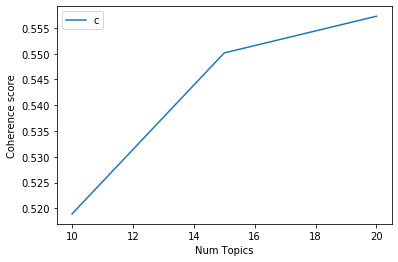

In [101]:
# Show graph
limit=25; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [102]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5189
Num Topics = 15  has Coherence Value of 0.5502
Num Topics = 20  has Coherence Value of 0.5573


In [103]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"human" + 0.013*"robot" + 0.011*"ethical" + 0.010*"issue" + '
  '0.010*"artificial" + 0.010*"intelligence" + 0.009*"initiative" + '
  '0.009*"ethic" + 0.008*"future" + 0.008*"technology"'),
 (1,
  '0.106*"datum" + 0.036*"data" + 0.023*"privacy" + 0.022*"protection" + '
  '0.018*"personal" + 0.014*"information" + 0.011*"individual" + '
  '0.010*"intelligence" + 0.010*"processing" + 0.009*"organisation"'),
 (2,
  '0.016*"professor" + 0.016*"evidence" + 0.016*"government" + '
  '0.014*"intelligence" + 0.013*"artificial" + 0.013*"write" + 0.011*"company" '
  '+ 0.009*"ready" + 0.009*"datum" + 0.009*"research"'),
 (3,
  '0.020*"ieee" + 0.019*"license" + 0.019*"ethics" + 0.019*"system" + '
  '0.018*"autonomous" + 0.016*"intelligent" + 0.015*"global" + 0.014*"design" '
  '+ 0.013*"human" + 0.012*"initiative"'),
 (4,
  '0.013*"system" + 0.012*"company" + 0.011*"worker" + 0.009*"recognition" + '
  '0.009*"report" + 0.009*"tech" + 0.008*"facial" + 0.008*"november" + '
  '0.006*"goo

### LSI MODEL

In [62]:
lsi_model = LsiModel(corpus, id2word=dictionary)
lsi_model.print_topics()

coherence_model= CoherenceModel(model=lsi_model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.5886301775914802


In [83]:
lsi_model.print_topics()

[(0,
  '0.274*"human" + 0.231*"datum" + 0.227*"technology" + 0.224*"system" + 0.156*"right" + 0.141*"decision" + 0.137*"make" + 0.136*"intelligence" + 0.126*"artificial" + 0.119*"also"'),
 (1,
  '-0.364*"datum" + 0.343*"human" + 0.309*"right" + 0.245*"submission" + 0.233*"technology" + 0.210*"australian" + -0.196*"machine" + 0.180*"decision" + 0.156*"rights" + -0.140*"learning"'),
 (2,
  '-0.342*"datum" + 0.247*"license" + 0.224*"ieee" + 0.223*"autonomous" + 0.206*"system" + 0.205*"ethics" + 0.191*"intelligent" + 0.163*"global" + 0.146*"initiative" + 0.140*"well"'),
 (3,
  '0.352*"datum" + 0.292*"machine" + -0.253*"intelligence" + -0.245*"artificial" + -0.189*"report" + -0.182*"number" + -0.166*"index" + -0.162*"country" + -0.157*"skill" + -0.140*"healthcare"'),
 (4,
  '-0.536*"healthcare" + -0.237*"health" + -0.229*"patient" + 0.192*"machine" + -0.171*"care" + 0.163*"artificial" + 0.160*"intelligence" + 0.132*"learning" + -0.132*"need" + -0.131*"solution"'),
 (5,
  '-0.475*"machine" +

### HSP MODEL

In [67]:
hdp_model = HdpModel(corpus, id2word=dictionary)
hdp_model.print_topics()

coherence_model= CoherenceModel(model=hdp_model, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.6822081125690874


In [68]:
hdp_model.print_topics()

[(0,
  '0.013*human + 0.009*system + 0.009*technology + 0.008*right + 0.006*datum + 0.005*decision + 0.005*ethical + 0.005*make + 0.005*design + 0.005*intelligence'),
 (1,
  '0.008*datum + 0.008*system + 0.008*algorithm + 0.007*social + 0.006*human + 0.006*technology + 0.006*ethical + 0.006*research + 0.005*machine + 0.005*artificial'),
 (2,
  '0.015*principle + 0.009*intelligence + 0.009*artificial + 0.009*datum + 0.009*system + 0.008*technology + 0.007*document + 0.007*human + 0.005*research + 0.005*government'),
 (3,
  '0.026*datum + 0.013*robot + 0.007*human + 0.006*machine + 0.006*data + 0.005*ethical + 0.005*intelligence + 0.005*technology + 0.005*protection + 0.005*artificial'),
 (4,
  '0.010*system + 0.007*intelligence + 0.006*artificial + 0.006*datum + 0.006*technology + 0.005*data + 0.005*report + 0.005*worker + 0.005*ethical + 0.005*work'),
 (5,
  '0.008*datum + 0.007*could + 0.006*public + 0.005*research + 0.005*make + 0.005*development + 0.005*system + 0.005*need + 0.005*t

## Contextualized Topic Model

I have not yet managed to make this one work... but it seemed promising from reading thir paper. See here: https://github.com/MilaNLProc/contextualized-topic-models

In [12]:
with open("/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/text_data_2.txt", "w") as text:
    for line in dataset["text"].values:
        text.write(str(line) + "\n")

with open("/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/text_data_lemmatized_2.txt", "w") as text:
    for line in lemmatized_dataset["text"].values:
        text.write(str(line) + "\n")


In [16]:
#dataset_path = "/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/full_text_dataset.csv"
#lemmatized_dataset_path = "/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/lemmatized_dataset.csv"
#dataset, lemmatized_dataset = read_dataset(dataset_path, lemmatized_dataset_path)

dictionary, corpus, text_data = convert_dataset(lemmatized_dataset)

text_data_path = "/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/text_data_2.txt"
text_data_path_lemm = "/users/marion1meyers/OneDrive/lawtechlab/ethics_ai_research/text_data_lemmatized_2.txt"

### Load data and train model

In [18]:
print('start handler')
handler = TextHandler(text_data_path_lemm)
handler.prepare()  # create vocabulary and training data

print('start generating Bert data')
# generate BERT data
training_bert = bert_embeddings_from_file(text_data_path, "distiluse-base-multilingual-cased")
#training_bert_2 = bert_embeddings_from_file(text_data_path_lemm, 'bert-base-nli-mean-tokens')

print('create CTM dataset')
#training_dataset = CTMDataset(handler.bow, training_bert, handler.idx2token)
training_dataset_2 = CTMDataset(handler.bow, training_bert_2, handler.idx2token)


#npmi = CoherenceNPMI(texts=dataset['text'], topics=ctm.get_topic_lists(10))
#npmi.score()

start handler
start generating Bert data


FileNotFoundError: [Errno 2] No such file or directory: '/Users/marion1meyers/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/modules.json'

In [16]:
print(training_dataset)

In [14]:
ctm = CTM(input_size=len(handler.vocab), bert_input_size=512, num_epochs=5, inference_type="combined",
          n_components=20)
print('fit the model')
ctm.fit(training_dataset)  # run the model

fit the model
Settings: 
               N Components: 20
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.95
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 20])

### Evaluate Model

In [ ]:
ctm.get_topic_lists(20)[0:10]

In [ ]:
td = TopicDiversity(ctm.get_topic_lists(25))
td.score(topk=25)

In [ ]:
rbo = InvertedRBO(ctm.get_topic_lists(10))
rbo.score()